In [1]:
## Spark session libraries
from pyspark import SparkContext
from pyspark import SQLContext

## Required for parsing the file as csv
import csv
from io import StringIO

## For Sorting
from re import compile as comp

## For Plots
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import cm, colors


import warnings

In [25]:
sc.stop()
sc = SparkContext(appName="SDDM", master='local[*]')

In [4]:
def parseCSV(csvRow) :
    data = StringIO(csvRow)
    dataReader = csv.reader(data, lineterminator = '')
    return(next(dataReader))


def readFileAsCSV(session, filepath):
    try:
        data = session.textFile(name = str(filepath))
        data = data.map(parseCSV)
    except:
        print('Failed to read the file!')
        data = []
    return data


def month(x):
    try:
        m = int(x[4][0:2])
    except:
        m = 'Issue Month'
    x.append(str(m))
    return x

def lat_long(x, coords):
    '''Not ready yet'''
    Zip = coords.take(1)[0].index('Zip')
    Geo = coords.take(1)[0].index('geopoint')
    
    Zip = list(map(lambda x: x[Zip], coords.collect()))
    Geo = list(map(lambda x: x[Geo].split(', '), coords.collect()))
    coords = [Zip, Geo]
    
    
def preprocessing(data, coords):
    '''
    Reads the csv files, and then converts Issue date to date and month
    '''
    #index = data.take(1)[0].index('Issue Date')
    data = data.map(month)
    #data = data.map(lat_long(coords))
    return data    

def preprocessedCSV(session, filepath, coords):
    return preprocessing(readFileAsCSV(session, filepath), coords)

In [11]:
def group_data(data, Val, Key):
    '''
    Groups data using key and values
    '''
    pairs = data.map(lambda x: (x[Key], x[Val]))
    return pairs.groupByKey().collect()

def group_data_toList(y, groupby):
    '''
    Input:
        - y: Grouped pyspark data returned from group_data function
        - groupby: Column name to remove an extra element
    '''
    lab = list(map(lambda x:x[0], y))
    val = list(map(lambda x:len(x[1]), y))
    try:
        kick = lab.index(groupby)
        lab.pop(kick)
        val.pop(kick)
    except:
        0
    if groupby=='Issue Month' or groupby == 'Violation Code':
        lab = list(map(lambda x: int(x), lab))
    return [lab,val]


def plot(ax, data, year, groupby, pt, plot_data):
    '''
    Input:
        - data: PySpark parsed CSV
        - groupby: Column name for grouping the data 
        - pt: Plot type
        - plot data: Variables required for bar plot
        
    Output: 
        - Plot
    '''
    if pt=='bar':
        col, val, axis_labels, legend_labels = plot_data
        
        cat_index = data.take(1)[0].index(col)
        
        cat1 = data.filter(lambda x: x[cat_index]==val)
        cat2 = data.filter(lambda x: x[cat_index]!=val)                   

        groupby_index = data.take(1)[0].index(groupby)
        count_column = data.take(1)[0].index('Summons Number')
        
        cat1 = group_data_toList(group_data(cat1 , Val=count_column, Key=groupby_index), groupby)
        cat2 = group_data_toList(group_data(cat2 , Val=count_column, Key=groupby_index), groupby)
            
        ## plotting the graph
        ax.bar(cat1[0], cat1[1], width = 0.5, label=legend_labels[0]) 
        ax.bar(cat2[0], cat2[1], width = 0.5, label=legend_labels[1])
        
        ax.legend()
        ax.set_xlabel(groupby, fontsize=18)
        ax.set_ylabel('Number of tickets', fontsize=18)
        ax.set_title('Parking tickets for the year '+str(year-1), fontsize=22)
    if pt == 'pie':
        try:
            groupby_index = data.take(1)[0].index(groupby)
            count_column = data.take(1)[0].index('Summons Number')
            
            label, data = group_data_toList(group_data(data , Val=count_column, Key=groupby_index), groupby)
            title = 'Parking ticket '+str(groupby)+' for the year '+str(year-1)
            
            if groupby == 'Violation Code': 
                ## Defining the violation code merges as a dictionary
                labs = {"Misc":[35,41,90,91,94],
                        "No Parking":[20,21,23,24,27],
                        "No Standing":[3,4,5,6,8,10,11,12,13,14,15,16,17,18,19,22,25,26,30,31,40,44,54,57,58,63,64,77,78,81,89,92],
                        "Permit/Doc Issue":[1,2,29,70,71,72,73,76,80,83,87,88,93,97],
                        "Plate Issues":[74,75,82],
                        "Obstructing Path":[7,9,36,45,46,47,48,49,50,51,52,53,55,56,59,60,61,62,66,67,68,79,84,96,98],
                        "Overtime":[28,32,33,34,37,38,39,42,43,65,69,85,86]
                        }
                ## Count based on the grouping
            
                temp = defaultdict(list)
                for i in range(len(label)):
                    for key, val in labs.items():
                        if label[i] in val:
                            if temp[key] == []:
                                temp[key] = 0
                            else:
                                temp[key] = temp[key]+data[i]

                ## Ordering data based on the dictionary 
                label, data  = list(), list()
                for key in labs.keys():
                    label.append(key)
                    data.append(temp[key])    

            ## Defining color for each category
            temp = defaultdict(list)
            for l,c in zip(labs,cm.tab20(range(len(labs)))):
                temp[l]=c

            centre_circle = plt.Circle((0,0),0.85,fc='white') ## radius to make it like a donut
            explode = np.full(len(label), 0.04) ## Gaps between the categories

            pat = ax.pie(list(map(lambda x: x*100/sum(data), data)), labels=label, autopct='%1.1f%%', startangle=90, pctdistance=0.6, explode = explode)
            if groupby == 'Violation Code':
                for pie_wedge in pat[0]:
                    pie_wedge.set_edgecolor('white')
                    pie_wedge.set_facecolor(temp[pie_wedge.get_label()]) # Assigning color code for each catergory

            ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
            ax.set_title(title, pad=20)
            plt.gcf().gca().add_artist(centre_circle)
        except:
            print('Failed to plot!')        
    return ax 

def EDA(tickets, year, groupby, pt, plotdim, plot_data):
    fig = plt.figure(figsize=(30, 25))
    axs=plt.GridSpec(plotdim[0], plotdim[1], hspace=0.15, wspace=0.1)
    for i in range(len(year)):
        plot(fig.add_subplot(axs[i]), tickets[i], year[i], groupby, pt, plot_data)
    plt.savefig('EDA_'+str(groupby)+'_'+str(pt)+'.png',  bbox_inches='tight')

In [13]:
def getData(sc, filepath, filename, year):
    tickets = []
    coords = readFileAsCSV(sc, str(filepath)+'us-zip-code-latitude-and-longitude.csv')
    for yr in year:
        filelocation = str(filepath)+str(filename)+str(yr)+".csv"
        print(filelocation)
        parking_data = preprocessedCSV(sc, filelocation, coords)
        tickets.append(parking_data)
    return tickets

In [14]:
filepath = 'SDDM Data/'
filename = 'Parking_Violations_Issued_-_Fiscal_Year_'
year = list(range(2015, 2021))

tickets = getData(sc, filepath, filename, year)

SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2015.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2016.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2017.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2018.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2019.csv
SDDM Data/Parking_Violations_Issued_-_Fiscal_Year_2020.csv


In [15]:
## Bar plot
category='Registration State'
value='NY' 
axis_labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']  
legend_labels= ['New York', 'Other Cities']
plot_data = [category, value, axis_labels, legend_labels]

NameError: name 'col' is not defined

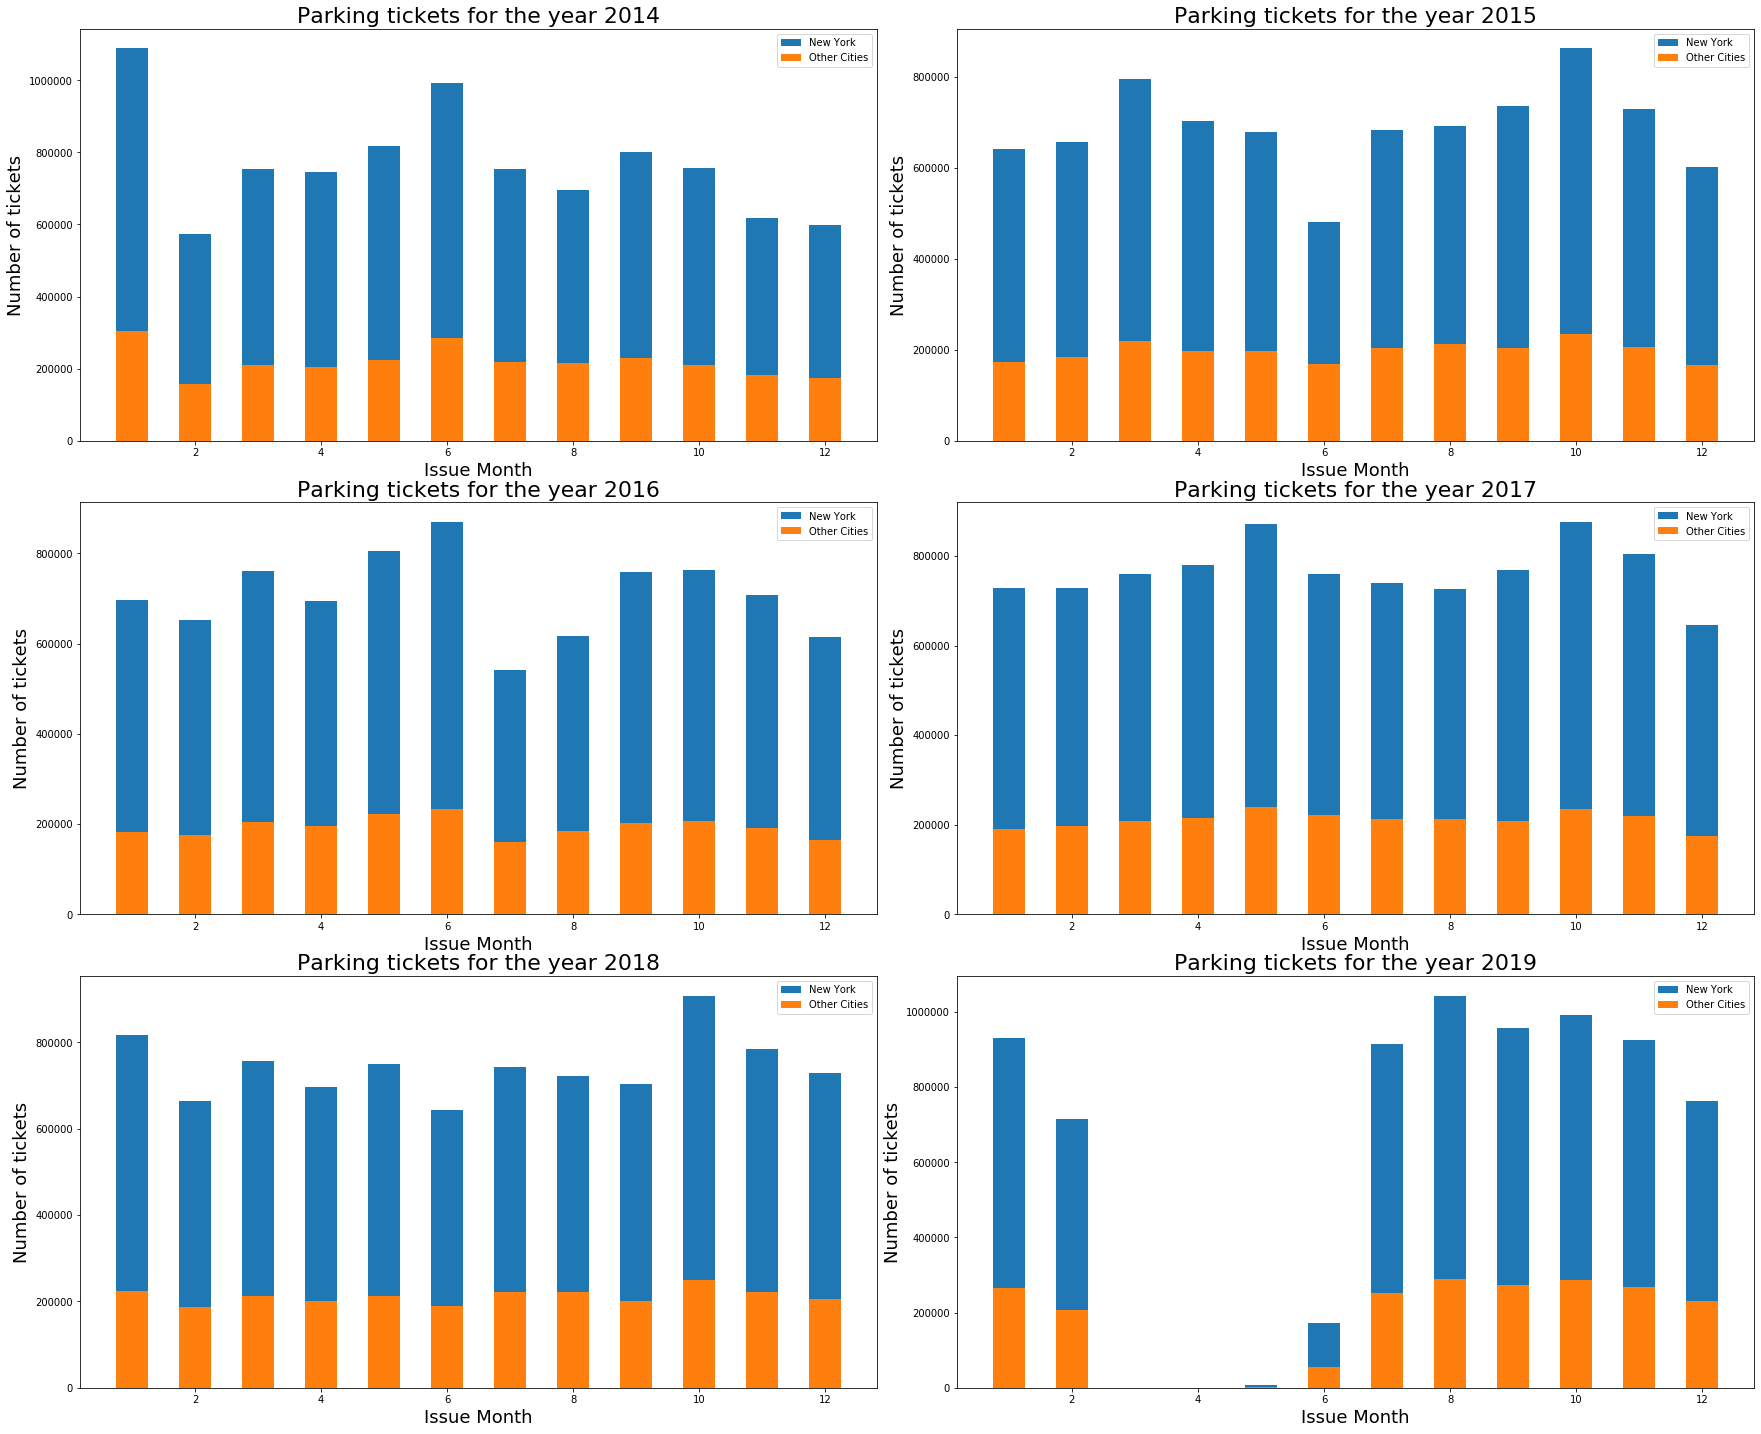

In [16]:
%%time

groupby = 'Issue Month'
EDA(tickets, year, groupby, 'bar', [int(len(year)/2),2], plot_data)

In [17]:
## Pie chart
%%time

groupby = 'Violation Code'
plot_data = []
EDA(tickets, year, groupby, 'pie', [int(len(year)/2),2], plot_data)

Failed to plot!
Failed to plot!
Failed to plot!


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f6194c37170> (for post_execute):


KeyboardInterrupt: 

In [19]:
sc.stop()